<a href="https://colab.research.google.com/github/Akhil-2001/ResNet50-Cancer-Cell-Classifier/blob/main/ResNet50-Breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading & Preprocessing

In [48]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import adam_v2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, recall_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [2]:
Adam=adam_v2.Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
subdir1=[]
dir1="/content/drive/MyDrive/SRE_01_Capstone_Material/BreaKHis_v1/40X/40X-benign/"
for dir in os.listdir(dir1):
  subdir1.append(dir)

In [5]:
len(subdir1)

16

In [6]:
subdir2=[]
dir2="/content/drive/MyDrive/SRE_01_Capstone_Material/BreaKHis_v1/40X/40X-malignant/"
for dir in os.listdir(dir2):
  subdir2.append(dir)

In [7]:
len(subdir2)

36

In [8]:
subdir2

['40X-7',
 '40X-32',
 '40X',
 '40X-9',
 '40X-27',
 '40X-23',
 '40X-1',
 '40X-4',
 '40X-17',
 '40X-2',
 '40X-24',
 '40X-8',
 '40X-13',
 '40X-25',
 '40X-29',
 '40X-14',
 '40X-5',
 '40X-22',
 '40X-15',
 '40X-35',
 '40X-30',
 '40X-26',
 '40X-21',
 '40X-6',
 '40X-19',
 '40X-34',
 '40X-18',
 '40X-31',
 '40X-11',
 '40X-28',
 '40X-20',
 '40X-12',
 '40X-16',
 '40X-10',
 '40X-3',
 '40X-33']

In [9]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG



In [10]:
benign=[]
for i in subdir1:
  benign.append(np.array(Dataset_loader(dir1+i,224)))

100%|██████████| 31/31 [00:08<00:00,  3.66it/s]


In [11]:
malignant=[]
for i in subdir2:
  malignant.append(np.array(Dataset_loader(dir2+i,224)))

100%|██████████| 30/30 [00:08<00:00,  3.50it/s]


In [12]:
import random

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
len(benign)

16

In [15]:
Benign=[]
for i in benign:
  for j in i:
    Benign.append(j)

In [16]:
Malign=[]
for i in malignant:
  for j in i:
    Malign.append(j)

In [17]:
random.shuffle(Benign)
benign_test, benign_train = train_test_split(Benign, train_size=0.75, test_size=0.25)

In [18]:
random.shuffle(Malign)
malign_test, malign_train = train_test_split(Malign, train_size=0.75, test_size=0.25)

# Create Label

In [19]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [20]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

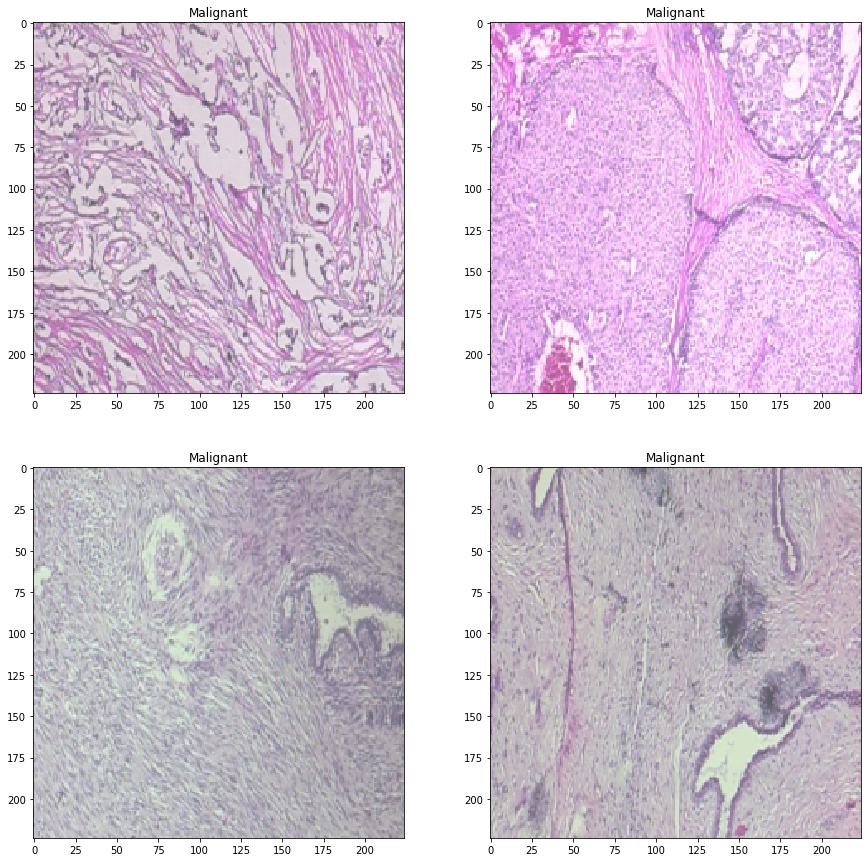

In [21]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 2
rows = 2

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [22]:
BATCH_SIZE = 8

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: ResNet50

In [42]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy','val_acc'],
    )
    
    return model

In [24]:
K.clear_session()
gc.collect()

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [26]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
31/31 [==============================] - 26s 235ms/step - loss: 0.8033 - accuracy: 0.6000 - val_loss: 0.4984 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 2/20
31/31 [==============================] - 4s 133ms/step - loss: 0.6986 - accuracy: 0.6600 - val_loss: 0.4902 - val_accuracy: 0.7460 - lr: 1.0000e-04
Epoch 3/20
31/31 [==============================] - 4s 134ms/step - loss: 0.6276 - accuracy: 0.7520 - val_loss: 0.4130 - val_accuracy: 0.8413 - lr: 1.0000e-04
Epoch 4/20
31/31 [==============================] - 4s 135ms/step - loss: 0.5642 - accuracy: 0.7560 - val_loss: 0.3596 - val_accuracy: 0.8571 - lr: 1.0000e-04
Epoch 5/20
31/31 [==============================] - 4s 134ms/step - loss: 0.5270 - accuracy: 0.7720 - val_loss: 0.7196 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 6/20
31/31 [==============================] - 4s 135ms/step - loss: 0.5325 - accuracy: 0.7920 - val_loss: 0.4131 - val_accuracy: 0.8413 - lr: 1.0000e-04
Epoch 7/20
31/31 [===========================

In [27]:
with open('history.json', 'w') as f:
  json.dump(str(history.history), f)

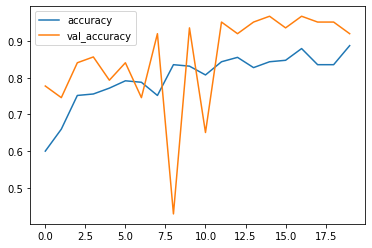

In [28]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

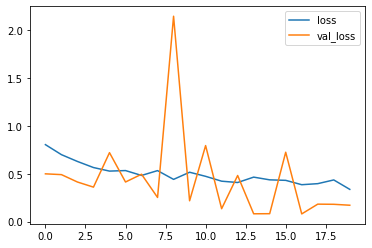

In [29]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [31]:
Y_val_pred = model.predict(x_val)

In [32]:
Y_val_pred

array([[6.5535283e-10, 1.0000000e+00],
       [1.0000000e+00, 7.6502199e-12],
       [5.6441832e-02, 9.4355822e-01],
       [9.9999452e-01, 5.5415676e-06],
       [5.6810402e-03, 9.9431902e-01],
       [2.3258931e-03, 9.9767417e-01],
       [3.5801697e-01, 6.4198309e-01],
       [1.0000000e+00, 9.7908851e-12],
       [6.5903086e-04, 9.9934095e-01],
       [5.9212698e-04, 9.9940789e-01],
       [1.0000000e+00, 3.6754200e-09],
       [4.7783650e-02, 9.5221633e-01],
       [6.0745619e-02, 9.3925440e-01],
       [4.4312989e-16, 1.0000000e+00],
       [4.0960833e-07, 9.9999964e-01],
       [1.3908598e-03, 9.9860913e-01],
       [8.9946395e-04, 9.9910057e-01],
       [1.0405653e-03, 9.9895942e-01],
       [9.9999738e-01, 2.5833997e-06],
       [1.3387933e-03, 9.9866116e-01],
       [9.5682180e-01, 4.3178141e-02],
       [9.9908268e-01, 9.1726490e-04],
       [5.6146227e-11, 1.0000000e+00],
       [2.1670606e-02, 9.7832936e-01],
       [1.6381338e-01, 8.3618659e-01],
       [6.3287945e-19, 1.

In [33]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9206349206349206

In [49]:
recall_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9574468085106383

In [34]:
Y_pred = model.predict(X_test)

In [35]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [02:21<00:00, 14.14s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[208  65]
 [ 33 632]]


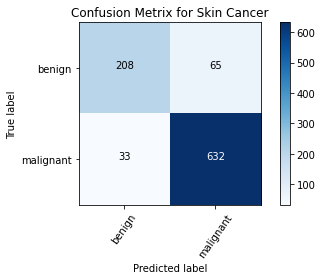

In [36]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[202  71]
 [ 17 648]]


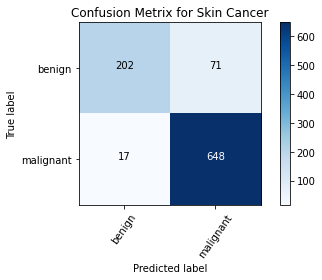

In [37]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [46]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82       273
           1       0.90      0.97      0.94       665

    accuracy                           0.91       938
   macro avg       0.91      0.86      0.88       938
weighted avg       0.91      0.91      0.90       938



### ROC and AUC

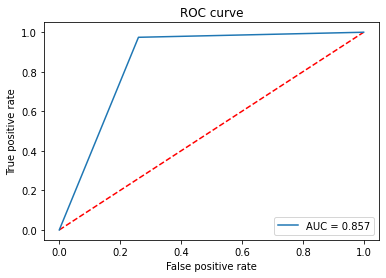

In [39]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

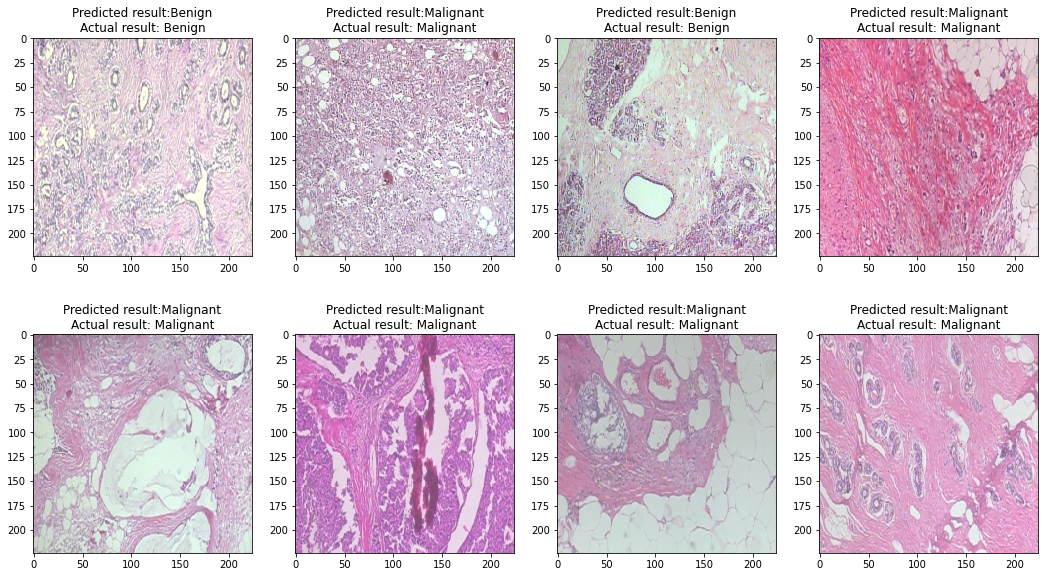

In [40]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()